In [2]:
#-----------------------------------------------------------------------------------------------------------
# INPE / CPTEC - Training: NWP Data Processing With Python - NWP Download with Python (GFS)
# Author: Diego Souza
#-----------------------------------------------------------------------------------------------------------

# Required modules
from datetime import datetime        # Basic Dates and time types
import os                            # Miscellaneous operating system interfaces
import requests                      # HTTP library for Python
import time as t                     # Time access and conversion                                          
#-----------------------------------------------------------------------------------------------------------

#print('---------------------------------------')
#print('GFS Download (NOMADS) - Script started.')
#print('---------------------------------------')

# Start the time counter
start_time = t.time()  

##########################################################################################################
# ALTERAR A DATA DESEJADA AQUI!!! 
# Desired date (last 10 days only!): Format - 'YYYY, MM, DD, HH'
##########################################################################################################
dt = datetime(2021, 2, 10, 12)
yyyymmddhhmn = (f'{dt:%Y%m%d%H}00') # Data e hora da imagem de satélite

#-----------------------------------------------------------------------------------------------------------

# Download directory
dir = "Samples"; os.makedirs(dir, exist_ok=True)

# Desired date (last 10 days only!): Format - 'YYYYMMDD'
#date = datetime.today().strftime('%Y%m%d')
date = (f'{dt:%Y%m%d}')

# Desired extent - COLOCAR AQUI ENTRE ASPAS POIS É UMA STRING
# longitude de -180 a 180
min_lon = '-122.50'
max_lon = '12.50'
min_lat = '-67.50'
max_lat = '12.50'

# Desired resolution: '25' or '50' or '1'
resolution = '1' 

# Desired run: '00' or '06' or '12' or '18'
#hour_run = '00'
hour_run=(f'{dt:%H}')

# Desired forecast hours
hour_ini = 0  # Init time  
hour_end = 0 # End time
hour_int = 3  # Interval

if (resolution == '25'):  
  res = 'pgrb2.0p'+resolution+'.f'
elif (resolution == '50'):
  res = 'pgrb2.0p'+resolution+'.f'
elif (resolution == '1'):
  res = 'pgrb2.'+resolution+'p00.f'

#-----------------------------------------------------------------------------------------------------------

# Link (select "grib filter" and check "Show the URL only for web programming" to verify the URL's):
# https://nomads.ncep.noaa.gov/

def download_gfs(date, iii):
    
    # Create the URL's based on the resolution    
    if (resolution == '25'):  
        url = 'https://nomads.ncep.noaa.gov/cgi-bin/filter_gfs_0p'+resolution+'.pl?file=gfs.t'+hour_run+'z.pgrb2.0p'+resolution+'.f'+str(hour).zfill(3)+'&all_lev=on&all_var=on&subregion=&leftlon='+min_lon+'&rightlon='+max_lon+'&toplat='+max_lat+'&bottomlat='+min_lat+'&dir=%2Fgfs.'+date+'%2F'+hour_run+'%2Fatmos' 
        file_name = 'gfs.t'+hour_run+'z.pgrb2.0p'+resolution+'.f'+str(hour).zfill(3)
        res = 'prgb2.0p'+resolution+'.f'
    elif (resolution == '50'):
        url = 'https://nomads.ncep.noaa.gov/cgi-bin/filter_gfs_0p'+resolution+'.pl?file=gfs.t'+hour_run+'z.pgrb2full.0p'+resolution+'.f'+str(hour).zfill(3)+'&all_lev=on&all_var=on&subregion=&leftlon='+min_lon+'&rightlon='+max_lon+'&toplat='+max_lat+'&bottomlat='+min_lat+'&dir=%2Fgfs.'+date+'%2F'+hour_run+'%2Fatmos' 
        file_name = 'gfs.t'+hour_run+'z.pgrb2.0p'+resolution+'.f'+str(hour).zfill(3)
        res = 'prgb2.0p'+resolution+'.f'
    elif (resolution == '1'):
        url = 'https://nomads.ncep.noaa.gov/cgi-bin/filter_gfs_'+resolution+'p00.pl?file=gfs.t'+hour_run+'z.pgrb2.'+resolution+'p00.f'+str(hour).zfill(3)+'&all_lev=on&all_var=on&subregion=&leftlon='+min_lon+'&rightlon='+max_lon+'&toplat='+max_lat+'&bottomlat='+min_lat+'&dir=%2Fgfs.'+date+'%2F'+hour_run+'%2Fatmos' 
        file_name = 'gfs.t'+hour_run+'z.pgrb2.'+resolution+'p00.f'+str(hour).zfill(3)
        res = 'prgb2.'+resolution+'p00.f'
    
    # Print the file name
    print("File name: ", file_name)
    # Sends a GET request to the specified url
    myfile = requests.get(url)
    
    # Download the file
    open(dir + '//' + file_name, 'wb').write(myfile.content)

#-----------------------------------------------------------------------------------------------------------
    
# Download loop
for hour in range(hour_ini, hour_end + 1, hour_int):
    print('\n---------------------')
    print('Downloading GFS File:')
    print('---------------------')
    print('Resolution: ' + resolution)
    print('Date: ' + date)
    print('Run: ' + hour_run)
    print('Forecast Hour: f' + str(hour).zfill(3))
    # Call the download function
    download_gfs(date,hour)

#-----------------------------------------------------------------------------------------------------------

# End the time counter
print('\nTotal Processing Time:', round((t.time() - start_time),2), 'seconds.') 


---------------------
---------------------
Resolution: 1
Date: 20210913
Run: 06
Forecast Hour: f000
File name:  gfs.t06z.pgrb2.1p00.f000

Total Processing Time: 49.16 seconds.


In [4]:
#-----------------------------------------------------------------------------------------------------------
# INPE / CPTEC - Training: Python and GOES-R Imagery: Script 22 - Satellite + NWP Plot (Example 3)
# Author: Diego Souza
#-----------------------------------------------------------------------------------------------------------
# Required modules
from netCDF4 import Dataset                         # Read / Write NetCDF4 files
from osgeo import gdal                              # Python bindings for GDAL
import matplotlib.pyplot as plt                     # Plotting library
import cartopy, cartopy.crs as ccrs                 # Plot maps
import cartopy.io.shapereader as shpreader          # Import shapefiles
import os                                           # Miscellaneous operating system interfaces
import numpy as np                                  # Scientific computing with Python
from matplotlib import cm                           # Colormap handling utilities
from datetime import timedelta, date, datetime      # Basic Dates and time types
from utilities import download_CMI                  # Our function for download
from utilities import reproject                     # Our function for reproject
from utilities import loadCPT                       # Import the CPT convert function
import pygrib                                       # Provides a high-level interface to the ECWMF ECCODES C library for reading GRIB files
gdal.PushErrorHandler('CPLQuietErrorHandler')       # Ignore GDAL warnings
#-----------------------------------------------------------------------------------------------------------

# Select the extent [min. lon, min. lat, max. lon, max. lat]
#lembrar que longitude está definida entre -180 e 180
extent = [float(min_lon), float(min_lat), float(max_lon), float(max_lat)] 

# Input and output directories
input = "Samples"; os.makedirs(input, exist_ok=True)
output = "Output"; os.makedirs(output, exist_ok=True)

#-----------------------------------------------------------------------------------------------------------
date = (f'{dt:%Y%m%d}')
yyyymmddhhmn = (f'{dt:%Y%m%d%H}00') # Data e hora da imagem de satélite
hour_run=(f'{dt:%H}')

# Download the ABI file channel 13 - Clean IR
file_ir = download_CMI(yyyymmddhhmn, 13, input)

#-----------------------------------------------------------------------------------------------------------
# Variable
var = 'CMI'

# Open the file
img = gdal.Open(f'NETCDF:{input}/{file_ir}.nc:' + var)

# Read the header metadata
metadata = img.GetMetadata()
scale = float(metadata.get(var + '#scale_factor'))
offset = float(metadata.get(var + '#add_offset'))
undef = float(metadata.get(var + '#_FillValue'))
dtime = metadata.get('NC_GLOBAL#time_coverage_start')

# Load the data
ds_cmi = img.ReadAsArray(0, 0, img.RasterXSize, img.RasterYSize).astype(float)

# Apply the scale, offset and convert to celsius
ds_cmi = (ds_cmi * scale + offset) - 273.15

# Reproject the file
filename_ret = f'{output}/IR_{yyyymmddhhmn}.nc'
reproject(filename_ret, img, ds_cmi, extent, undef)

# Open the reprojected GOES-R image
file = Dataset(filename_ret)

# Get the pixel values
data = file.variables['Band1'][:]
#----------------------------------------------------------------------------------------------------------- 


In [5]:
# Open the GRIB file
grib = pygrib.open(f'Samples/gfs.t{hour_run}z.{res}000')
 
# Select the variable
mslp = grib.select(name='Pressure reduced to MSL')[0]

# Get information from the file    
init  = str(mslp.analDate)      # Init date / time
init  = str(mslp.analDate)      # Init date / time
run   = str(mslp.hour).zfill(2) # Run
ftime = str(mslp.forecastTime)  # Forecast hour
valid = str(mslp.validDate)     # Valid date / time 
#print('Init: ' + init + ' UTC')
#print('Run: ' + run + 'Z')
#print('Forecast: +' + ftime)
#print('Valid: ' + valid + ' UTC')

# Read the data for a specific region
# longitude tem que estar entre 0 e 360 graus
mslp, lats, lons = mslp.data(lat1=extent[1],lat2=extent[3],lon1=extent[0],lon2=extent[2])

# Convert to hPa
mslp = mslp / 100

#-----------------------------------------------------------------------------------------------------------

# Select the variable
hght_1000 = grib.select(name='Geopotential Height', typeOfLevel = 'isobaricInhPa', level = 1000)[0]
# Read the data for a specific region
hght_1000 = hght_1000.data(lat1=extent[1],lat2=extent[3],lon1=extent[0],lon2=extent[2])[0]

# Select the variable
hght_850 = grib.select(name='Geopotential Height', typeOfLevel = 'isobaricInhPa', level = 850)[0]
# Read the data for a specific region
hght_850 = hght_850.data(lat1=extent[1],lat2=extent[3],lon1=extent[0],lon2=extent[2])[0]

# Select the variable
hght_500 = grib.select(name='Geopotential Height', typeOfLevel = 'isobaricInhPa', level = 500)[0]
# Read the data for a specific region
hght_500 = hght_500.data(lat1=extent[1],lat2=extent[3],lon1=extent[0],lon2=extent[2])[0]

# Select the variable
hght_250 = grib.select(name='Geopotential Height', typeOfLevel = 'isobaricInhPa', level = 250)[0]
# Read the data for a specific region
hght_250 = hght_250.data(lat1=extent[1],lat2=extent[3],lon1=extent[0],lon2=extent[2])[0]

# Calculate and smooth 1000-500 hPa thickness
thickness_1000_500 = hght_500 - hght_1000

# Calculate and smooth 1000-850 hPa thickness
thickness_1000_850 = hght_850 - hght_1000

# Select the variable
temp_850 = grib.select(name='Temperature', typeOfLevel = 'isobaricInhPa', level = 850)[0]
# Read the data for a specific region
temp_850 = temp_850.data(lat1=extent[1],lat2=extent[3],lon1=extent[0],lon2=extent[2])[0]

# Select the variable
temp_500 = grib.select(name='Temperature', typeOfLevel = 'isobaricInhPa', level = 500)[0]
# Read the data for a specific region
temp_500 = temp_500.data(lat1=extent[1],lat2=extent[3],lon1=extent[0],lon2=extent[2])[0]

# Select the variable
temp_250 = grib.select(name='Temperature', typeOfLevel = 'isobaricInhPa', level = 250)[0]
# Read the data for a specific region
temp_250 = temp_250.data(lat1=extent[1],lat2=extent[3],lon1=extent[0],lon2=extent[2])[0]

# Select the variable
spch_850 = grib.select(name='Specific humidity', typeOfLevel = 'isobaricInhPa', level = 850)[0]
# Read the data for a specific region
spch_850 = spch_850.data(lat1=extent[1],lat2=extent[3],lon1=extent[0],lon2=extent[2])[0]

#-----------------------------------------------------------------------------------------------------------
# Select the variable
u_1000 = grib.select(name='U component of wind', typeOfLevel = 'isobaricInhPa', level = 1000)[0]
# Read the data for a specific region
u_1000, lats, lons = u_1000.data(lat1=extent[1],lat2=extent[3],lon1=extent[0],lon2=extent[2])
# Select the variable
v_1000 = grib.select(name='V component of wind', typeOfLevel = 'isobaricInhPa', level = 1000)[0]
# Read the data for a specific region
v_1000 = v_1000.data(lat1=extent[1],lat2=extent[3],lon1=extent[0],lon2=extent[2])[0]

# Select the variable
u_850 = grib.select(name='U component of wind', typeOfLevel = 'isobaricInhPa', level = 850)[0]
# Read the data for a specific region
u_850, lats, lons = u_850.data(lat1=extent[1],lat2=extent[3],lon1=extent[0],lon2=extent[2])
# Select the variable
v_850 = grib.select(name='V component of wind', typeOfLevel = 'isobaricInhPa', level = 850)[0]
# Read the data for a specific region
v_850 = v_850.data(lat1=extent[1],lat2=extent[3],lon1=extent[0],lon2=extent[2])[0]

# Select the variable
u_500 = grib.select(name='U component of wind', typeOfLevel = 'isobaricInhPa', level = 500)[0]
# Read the data for a specific region
u_500, lats, lons = u_500.data(lat1=extent[1],lat2=extent[3],lon1=extent[0],lon2=extent[2])
# Select the variable
v_500 = grib.select(name='V component of wind', typeOfLevel = 'isobaricInhPa', level = 500)[0]
# Read the data for a specific region
v_500 = v_500.data(lat1=extent[1],lat2=extent[3],lon1=extent[0],lon2=extent[2])[0]
# Select the variable
w_500 = grib.select(name='Vertical velocity', typeOfLevel = 'isobaricInhPa', level = 500)[0]
# Read the data for a specific region
w_500 = w_500.data(lat1=extent[1],lat2=extent[3],lon1=extent[0],lon2=extent[2])[0]

# Select the variable
u_250 = grib.select(name='U component of wind', typeOfLevel = 'isobaricInhPa', level = 250)[0]
# Read the data for a specific region
u_250, lats, lons = u_250.data(lat1=extent[1],lat2=extent[3],lon1=extent[0],lon2=extent[2])
# Select the variable
v_250 = grib.select(name='V component of wind', typeOfLevel = 'isobaricInhPa', level = 250)[0]
# Read the data for a specific region
v_250 = v_250.data(lat1=extent[1],lat2=extent[3],lon1=extent[0],lon2=extent[2])[0]
#-----------------------------------------------------------------------------------------------------------
from metpy.units import units
import metpy.calc as mpcalc
import numpy.ma as ma

nivel=850
pressure = units('Pa')*nivel*100
u_850 = units('m/s')*u_850
v_850 = units('m/s')*v_850
temp_850 = units('K')*temp_850
# Calculando com metpy
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

# Compute the Q-vector components
uqvect, vqvect = mpcalc.q_vector(u = u_850, v = v_850, temperature=temp_850, pressure=pressure, dx=dx, dy=dy)
# Compute the divergence of the Q-vectors calculated above
q_div = 2*mpcalc.divergence(uqvect, vqvect, dx=dx, dy=dy)
# Calculate potential temperature for frontogenesis calculation
theta = mpcalc.potential_temperature(pressure = pressure, temperature = temp_850)
#Calculando metpy.calc.dewpoint_from_specific_humidity(pressure, temperature, specific_humidity)
dewp = mpcalc.dewpoint_from_specific_humidity(pressure = pressure, temperature = temp_850, specific_humidity = spch_850)
thetae = mpcalc.equivalent_potential_temperature(pressure = pressure, temperature = temp_850, dewpoint = dewp)
# Calculate frontogenesis: metpy.calc.frontogenesis(potential_temperature, u, v, dx=None, dy=None, x_dim=- 1, y_dim=- 2)
fronto = mpcalc.frontogenesis(potential_temperature = theta, u = u_850, v = v_850, dx = dx, dy = dy)
# A conversion factor to get frontogensis units of K per 100 km per 3 h
convert_to_per_100km_3h = 1000*100*3600*3
#Calculando metpy.calc.vorticity(u, v, *, dx=None, dy=None, x_dim=- 1, y_dim=- 2)
zeta_850 = mpcalc.vorticity(u_850,v_850, dx = dx, dy = dy)
#Quero somente os valores menores que 0
mask_zeta = ma.masked_greater_equal(zeta_850, 0).mask
zeta_850[mask_zeta] = np.nan
# Calculate temperature advection using metpy function metpy.calc.advection(scalar, u=None, v=None, w=None, *, dx=None, dy=None, dz=None, x_dim=- 1, y_dim=- 2, vertical_dim=- 3)
T = temp_850
adv = mpcalc.advection(T, u = u_850, v = v_850, dx = dx, dy = dy)

# Smooth heights and advection a little
# Be sure to only put in a 2D lat/lon or Y/X array for smoothing
adv = mpcalc.smooth_gaussian(adv, 2)

nivel=500
pressure = units('Pa')*nivel*100
u_500 = units('m/s')*u_500
v_500 = units('m/s')*v_500
temp_500 = units('K')*temp_500
# Calculando com metpy
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

# Compute the Q-vector components
#uqvect_500, vqvect_500 = mpcalc.q_vector(u = u_500, v = v_500, temperature=temp_500, pressure=pressure, dx=dx, dy=dy)
# Compute the divergence of the Q-vectors calculated above
#q_div_500 = 2*mpcalc.divergence(uqvect_500, vqvect_500, dx=dx, dy=dy)
#Calculando metpy.calc.vorticity(u, v, *, dx=None, dy=None, x_dim=- 1, y_dim=- 2)
zeta_500 = mpcalc.vorticity(u_500,v_500, dx = dx, dy = dy)
#Quero somente os valores menores que 0
#mask_zeta = ma.masked_greater_equal(zeta_500, 0).mask
#zeta_500[mask_zeta] = np.nan
# Calculate vorticity advection using metpy function metpy.calc.advection(scalar, u=None, v=None, w=None, *, dx=None, dy=None, dz=None, x_dim=- 1, y_dim=- 2, vertical_dim=- 3)
T = zeta_500
adv_zeta = mpcalc.advection(T, u = u_500, v = v_500, dx = dx, dy = dy)

# Smooth heights and advection a little
# Be sure to only put in a 2D lat/lon or Y/X array for smoothing
adv_zeta = mpcalc.smooth_gaussian(adv_zeta, 2)

nivel=250
pressure = units('Pa')*nivel*100
u_250 = units('m/s')*u_250
v_250 = units('m/s')*v_250
temp_250 = units('K')*temp_250
# Calculando com metpy
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

# Compute the Q-vector components
uqvect_250, vqvect_250 = mpcalc.q_vector(u = u_250, v = v_250, temperature=temp_250, pressure=pressure, dx=dx, dy=dy)
# Compute the divergence of the Q-vectors calculated above
q_div_250 = 2*mpcalc.divergence(uqvect_250, vqvect_250, dx=dx, dy=dy)

# Use MetPy to calculate the wind speed for colorfill plot, change units to knots from m/s
speed_jet = mpcalc.wind_speed(u_250, v_250)

#Quero somente os valores maiores que 30 m/s
mask_jet = ma.masked_less_equal(speed_jet, 30).mask
speed_jet[mask_jet] = np.nan


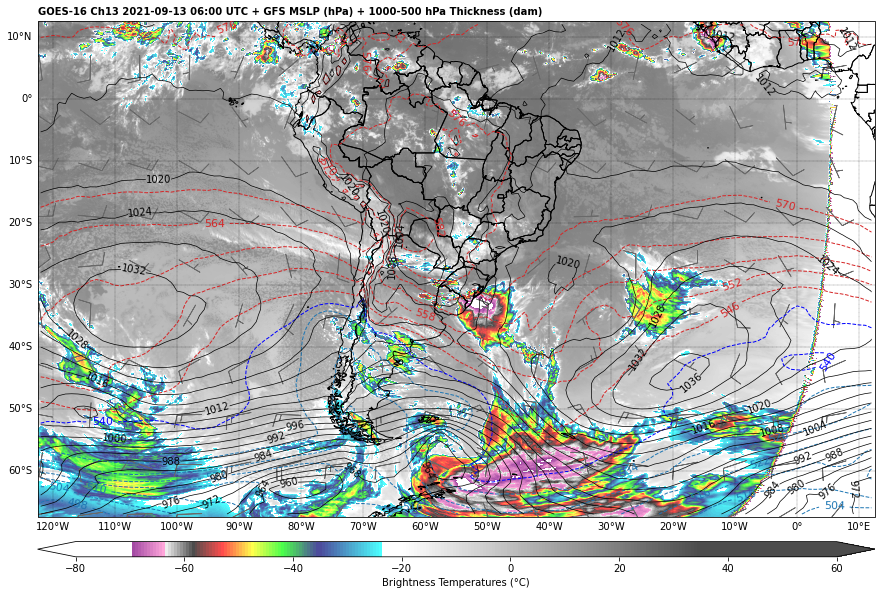

In [7]:
# plotando sat + mslp + esp + vbarbs
# Choose the plot size (width x height, in inches)
plt.figure(figsize=(15,15))

# Use the Geostationary projection in cartopy
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([extent[0], extent[2], extent[1], extent[3]], ccrs.PlateCarree())

# Define the image extent
img_extent = [extent[0], extent[2], extent[1], extent[3]]

# Define the color scale based on the channel
# Converts a CPT file to be used in Python
cpt = loadCPT('IR4AVHRR6.cpt')
colormap = cm.colors.LinearSegmentedColormap('cpt', cpt) 
    
# Plot the image
img1 = ax.imshow(data, origin='upper', vmin=-80, vmax=60, extent=img_extent, cmap=colormap, alpha=0.7)
# Add a colorbar
plt.colorbar(img1, label='Brightness Temperatures (°C)', extend='both', orientation='horizontal', pad=0.03, aspect = 50)

# Plot thickness with multiple colors
clevs = (np.arange(0, 540, 6),
         np.array([540]),
         np.arange(546, 700, 6))
colors = ('tab:blue', 'b', 'tab:red')
kw_clabels = {'fontsize': 11, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}
for clevthick, color in zip(clevs, colors):
    img2 = ax.contour(lons, lats, thickness_1000_500/10, levels=clevthick, colors=color,
                    linewidths=1.0, linestyles='dashed', transform=ccrs.PlateCarree())
    plt.clabel(img2, **kw_clabels)

# Define de contour interval
data_min = 900
data_max = 1050
interval = 4
levels = np.arange(data_min,data_max,interval)

# Plot the contours
img3 = ax.contour(lons, lats, mslp, colors='black', linewidths=0.7, levels=levels)
ax.clabel(img3, inline=1, inline_spacing=0, fontsize='10',fmt = '%1.0f', colors= 'black')


# Create a flag to determine which barbs are flipped
flip_flag = np.zeros((u_1000.shape[0],u_1000.shape[1]))

# All flags below the equator will be flipped
flip_flag[lats < 0] = 1

# Plot the barbs
skip=8
bcolor='dimgrey'
img4 = ax.barbs(lons[::skip,::skip], lats[::skip,::skip], u_1000[::skip,::skip], v_1000[::skip,::skip], length = 7.0, sizes = dict(emptybarb=0.0, spacing=0.2, height=0.5), linewidth=0.8, pivot='middle', barbcolor=bcolor, flip_barb = flip_flag[::skip,::skip])

import cartopy.feature as cfeature

states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)
# Add country borders to plot
country_borders = cfeature.NaturalEarthFeature(category='cultural',
                                               name='admin_0_countries',
                                               scale='50m', facecolor='none')
ax.add_feature(country_borders, edgecolor='black', linewidth=1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='black', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 10), ylocs=np.arange(-90, 90, 10), draw_labels=True)
gl.top_labels = False
gl.right_labels = False


# Extract date
date = (datetime.strptime(dtime, '%Y-%m-%dT%H:%M:%S.%fZ'))

# Add a title
plt.title('GOES-16 Ch13 ' + date.strftime('%Y-%m-%d %H:%M') + ' UTC' + ' + GFS MSLP (hPa) + 1000-500 hPa Thickness (dam)', fontweight='bold', fontsize=10, loc='left')
#plt.title('Reg.: ' + str(extent) , fontsize=10, loc='right')
#-----------------------------------------------------------------------------------------------------------
# Save the image
plt.savefig(f'{output}/Sat_mslp_Esp_V.png', bbox_inches='tight', pad_inches=0, dpi=300)

# Show the image
plt.show()


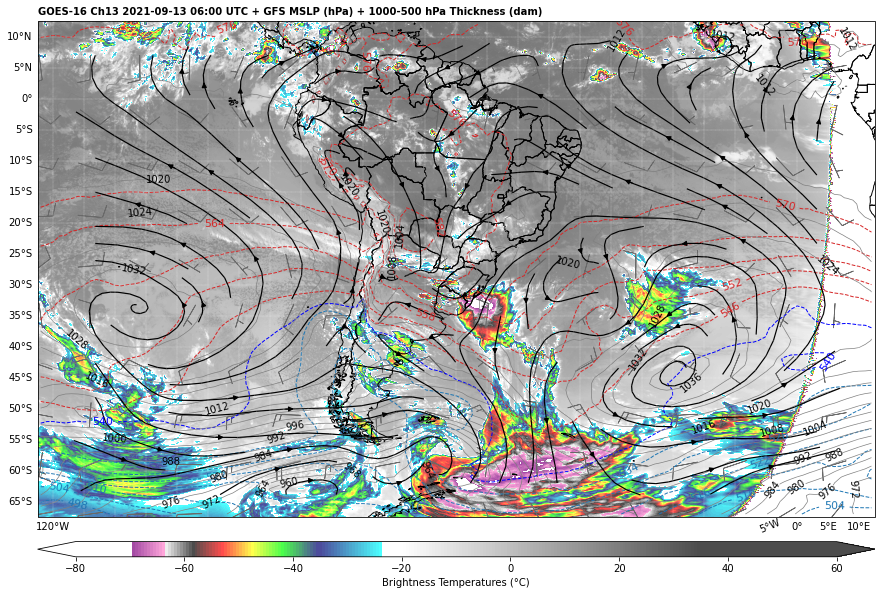

In [8]:
# plotando sat + mslp + esp + vbarbs
# Choose the plot size (width x height, in inches)
plt.figure(figsize=(15,15))

# Use the Geostationary projection in cartopy
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([extent[0], extent[2], extent[1], extent[3]], ccrs.PlateCarree())

# Define the image extent
img_extent = [extent[0], extent[2], extent[1], extent[3]]

# Define the color scale based on the channel
# Converts a CPT file to be used in Python
cpt = loadCPT('IR4AVHRR6.cpt')
colormap = cm.colors.LinearSegmentedColormap('cpt', cpt) 
    
# Plot the image
img1 = ax.imshow(data, origin='upper', vmin=-80, vmax=60, extent=img_extent, cmap=colormap, alpha=0.7)
# Add a colorbar
plt.colorbar(img1, label='Brightness Temperatures (°C)', extend='both', orientation='horizontal', pad=0.03, aspect = 50)

# Plot thickness with multiple colors
clevs = (np.arange(0, 540, 6),
         np.array([540]),
         np.arange(546, 700, 6))
colors = ('tab:blue', 'b', 'tab:red')
kw_clabels = {'fontsize': 11, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}
for clevthick, color in zip(clevs, colors):
    img2 = ax.contour(lons, lats, thickness_1000_500/10, levels=clevthick, colors=color,
                    linewidths=1.0, linestyles='dashed', transform=ccrs.PlateCarree())
    plt.clabel(img2, **kw_clabels)

# Define de contour interval
data_min = 900
data_max = 1050
interval = 4
levels = np.arange(data_min,data_max,interval)

# Plot the contours
img3 = ax.contour(lons, lats, mslp, colors='grey', linewidths=0.7, levels=levels)
ax.clabel(img3, inline=1, inline_spacing=0, fontsize='10',fmt = '%1.0f', colors= 'black')


# Create a flag to determine which barbs are flipped
flip_flag = np.zeros((u_1000.shape[0],u_1000.shape[1]))

# All flags below the equator will be flipped
flip_flag[lats < 0] = 1

# Plot the barbs
skip=8
bcolor='dimgrey'
img4 = ax.barbs(lons[::skip,::skip], lats[::skip,::skip], u_1000[::skip,::skip], v_1000[::skip,::skip], length = 7.0, sizes = dict(emptybarb=0.0, spacing=0.2, height=0.5), linewidth=0.8, pivot='middle', barbcolor=bcolor, flip_barb = flip_flag[::skip,::skip])

ax.streamplot(lons, lats, u_1000, v_1000, density=[1, 1], linewidth=1.2, color='black')


states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)
# Add country borders to plot
country_borders = cfeature.NaturalEarthFeature(category='cultural',
                                               name='admin_0_countries',
                                               scale='50m', facecolor='none')
ax.add_feature(country_borders, edgecolor='black', linewidth=1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='white', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 5), ylocs=np.arange(-90, 90, 5), draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Use definition to plot H/L symbols
#plot_maxmin_points(lons, lats, prmls, 'max', 50, symbol='H', color='b',  transform=ccrs.PlateCarree())
#plot_maxmin_points(lons, lats, prmls, 'min', 25, symbol='L', color='r', transform=ccrs.PlateCarree())

# Extract date
date = (datetime.strptime(dtime, '%Y-%m-%dT%H:%M:%S.%fZ'))

# Add a title
plt.title('GOES-16 Ch13 ' + date.strftime('%Y-%m-%d %H:%M') + ' UTC' + ' + GFS MSLP (hPa) + 1000-500 hPa Thickness (dam)', fontweight='bold', fontsize=10, loc='left')
#plt.title('Reg.: ' + str(extent) , fontsize=10, loc='right')
#-----------------------------------------------------------------------------------------------------------
# Save the image
plt.savefig(f'{output}/Sat_mslp_Esp_V_LC.png', bbox_inches='tight', pad_inches=0, dpi=300)

# Show the image
plt.show()


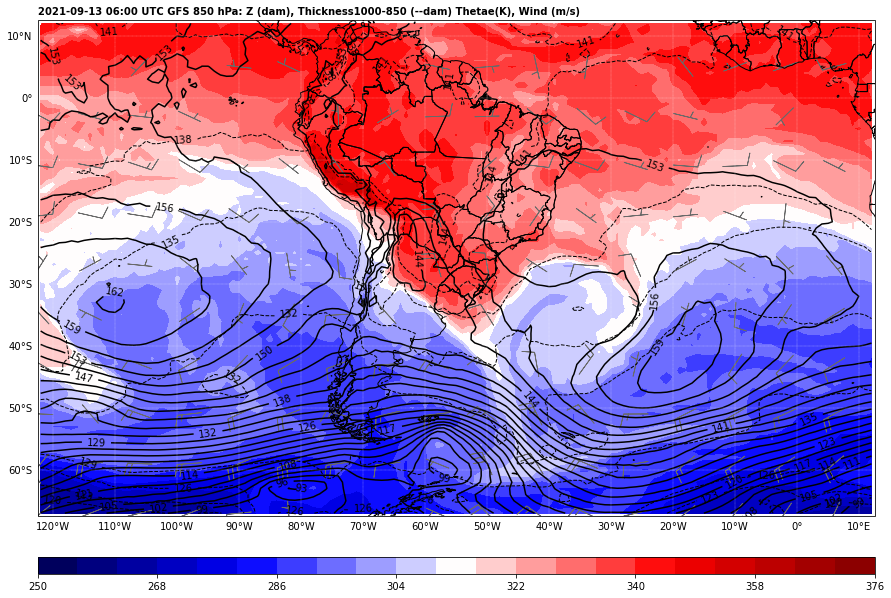

In [12]:
# Plotando 850: Z, thetae,vbarbs

# Choose the plot size (width x height, in inches)
plt.figure(figsize=(15,15))

# Use the Geostationary projection in cartopy
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([extent[0], extent[2], extent[1], extent[3]], ccrs.PlateCarree())

# Define the image extent
img_extent = [extent[0], extent[2], extent[1], extent[3]]

# 850-hPa thetae
clevte = np.arange(250, 377, 6)
cmap='nipy_spectral'
te = ax.contourf(lons, lats, thetae, clevte, cmap='seismic', transform=ccrs.PlateCarree())
plt.colorbar(te, orientation='horizontal', pad=0.05, aspect=50, extendrect=True)

# Plot thickness with multiple color
clevs = np.arange(0, 540, 3)
cs0 = ax.contour(lons, lats, thickness_1000_850/10, clevs, colors='black',linewidths=1.0, linestyles='dashed', transform=ccrs.PlateCarree())
plt.clabel(cs0, fmt='%d')

# Plot Geopotential Heights
clevs_hght_850 = np.arange(0, 800, 3)
cs = ax.contour(lons, lats, hght_850/10, clevs_hght_850, colors='black', transform=ccrs.PlateCarree())
plt.clabel(cs, fmt='%d')

# Create a flag to determine which barbs are flipped
flip_flag = np.zeros((u_850.shape[0],u_850.shape[1]))

# All flags below the equator will be flipped
flip_flag[lats < 0] = 1

# Plot the barbs
skip=8
bcolor='dimgrey'
img4 = ax.barbs(lons[::skip,::skip], lats[::skip,::skip], u_850[::skip,::skip], v_850[::skip,::skip], length = 7.0, sizes = dict(emptybarb=0.0, spacing=0.2, height=0.5), linewidth=0.8, pivot='middle', barbcolor=bcolor, flip_barb = flip_flag[::skip,::skip])

states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)
# Add country borders to plot
country_borders = cfeature.NaturalEarthFeature(category='cultural',
                                               name='admin_0_countries',
                                               scale='50m', facecolor='none')
ax.add_feature(country_borders, edgecolor='black', linewidth=1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='white', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 10), ylocs=np.arange(-90, 90, 10), draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Extract date
date = (datetime.strptime(dtime, '%Y-%m-%dT%H:%M:%S.%fZ'))

# Add a title
plt.title(date.strftime('%Y-%m-%d %H:%M') + ' UTC GFS 850 hPa: Z (dam), Thickness1000-850 (--dam) Thetae(K), Wind (m/s)', fontweight='bold', fontsize=10, loc='left')
#plt.title('Reg.: ' + str(extent) , fontsize=10, loc='right')
#-----------------------------------------------------------------------------------------------------------
# Save the image
plt.savefig(f'{output}/850_thetae.png', bbox_inches='tight', pad_inches=0, dpi=300)

# Show the image
plt.show()


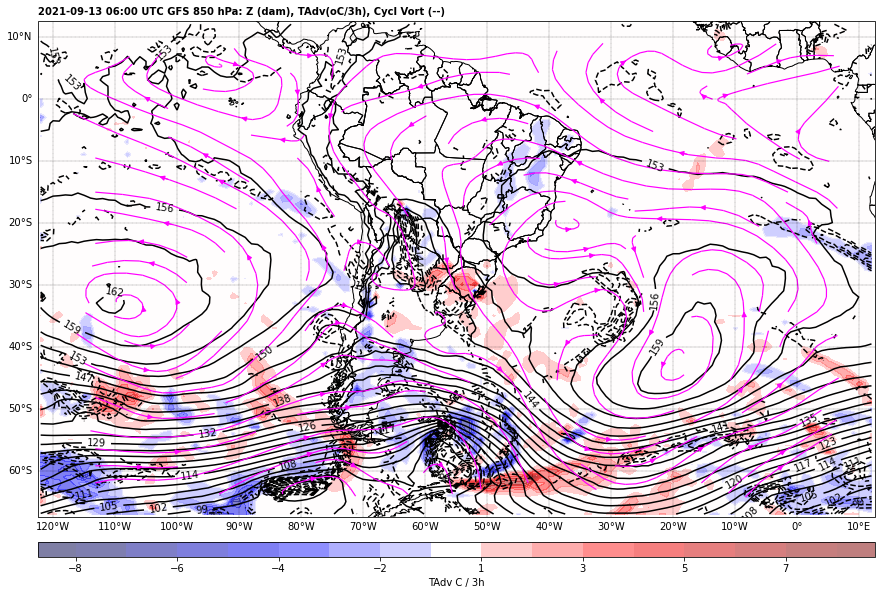

In [9]:
# Plotando 850: Z, vort,advT

# Choose the plot size (width x height, in inches)
plt.figure(figsize=(15,15))

# Use the Geostationary projection in cartopy
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([extent[0], extent[2], extent[1], extent[3]], ccrs.PlateCarree())

# Define the image extent
img_extent = [extent[0], extent[2], extent[1], extent[3]]

# Define the color scale based on the channel
# Converts a CPT file to be used in Python
cpt = loadCPT('IR4AVHRR6.cpt')
colormap = cm.colors.LinearSegmentedColormap('cpt', cpt) 
    
# Plot the image
#img1 = ax.imshow(data, origin='upper', vmin=-80, vmax=60, extent=img_extent, cmap=colormap, alpha=0.7)
# Add a colorbar
#plt.colorbar(img1, label='Brightness Temperatures (°C)', extend='both', orientation='horizontal', pad=0, aspect = 50)


# 850-hPa Colorfill of Temperature Advection
cint = np.arange(-8, 9,1)
cf = ax.contourf(lons, lats, 3*adv.to(units('delta_degC/hour')), cint[cint != 0],
                 extend='both', cmap='seismic', transform=ccrs.PlateCarree(), alpha=0.5)
cb = plt.colorbar(cf, orientation='horizontal', pad=0.03, aspect=50, extendrect=True)
cb.set_label('TAdv C / 3h')

# Plot Geopotential Heights
clevs_hght_850 = np.arange(0, 800, 3)
cs = ax.contour(lons, lats, hght_850/10, clevs_hght_850, colors='black', transform=ccrs.PlateCarree())
plt.clabel(cs, fmt='%d')

# 850-hPa vort
clevzeta = np.arange(-50, 0, 2)
zeta = ax.contour(lons, lats, zeta_850*10**5, clevzeta, colors='black', transform=ccrs.PlateCarree())
#plt.colorbar(zeta, orientation='horizontal', pad=0.05, aspect=50, extendrect=True)

ax.streamplot(lons, lats, u_850, v_850, density=[1, 1], linewidth=1.2, color='magenta')

states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)
# Add country borders to plot
country_borders = cfeature.NaturalEarthFeature(category='cultural',
                                               name='admin_0_countries',
                                               scale='50m', facecolor='none')
ax.add_feature(country_borders, edgecolor='black', linewidth=1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='black', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 10), ylocs=np.arange(-90, 90, 10), draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Extract date
date = (datetime.strptime(dtime, '%Y-%m-%dT%H:%M:%S.%fZ'))

# Add a title
plt.title(date.strftime('%Y-%m-%d %H:%M') + ' UTC' + ' GFS 850 hPa: Z (dam), TAdv(oC/3h), Cycl Vort (--)', fontweight='bold', fontsize=10, loc='left')
#plt.title('Reg.: ' + str(extent) , fontsize=10, loc='right')
#-----------------------------------------------------------------------------------------------------------
# Save the image
plt.savefig(f'{output}/850_advT_Vort.png', bbox_inches='tight', pad_inches=0, dpi=300)

# Show the image
plt.show()


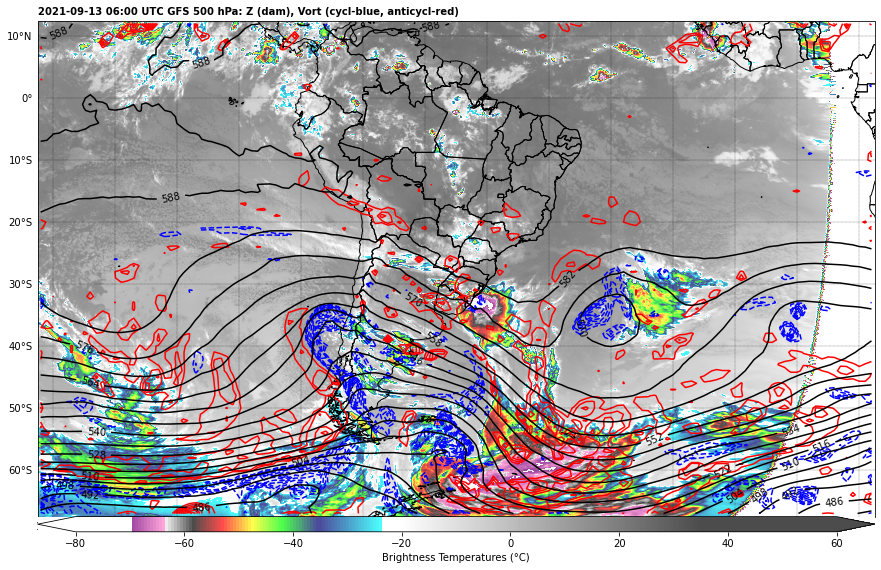

In [13]:
# Plotando 500: Z, vort,advZeta

# Choose the plot size (width x height, in inches)
plt.figure(figsize=(15,15))

# Use the Geostationary projection in cartopy
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([extent[0], extent[2], extent[1], extent[3]], ccrs.PlateCarree())

# Define the image extent
img_extent = [extent[0], extent[2], extent[1], extent[3]]

# Define the color scale based on the channel
# Converts a CPT file to be used in Python
cpt = loadCPT('IR4AVHRR6.cpt')
colormap = cm.colors.LinearSegmentedColormap('cpt', cpt) 
    
# Plot the image
img1 = ax.imshow(data, origin='upper', vmin=-80, vmax=60, extent=img_extent, cmap=colormap, alpha=0.7)
# Add a colorbar
plt.colorbar(img1, label='Brightness Temperatures (°C)', extend='both', orientation='horizontal', pad=0, aspect = 50)

# 500-hPa vort
clevzeta = np.arange(-50, -4, 2)
zeta = ax.contour(lons, lats, zeta_500*10**5, clevzeta, colors='blue', transform=ccrs.PlateCarree())
#plt.colorbar(zeta, orientation='horizontal', pad=0.05, aspect=50, extendrect=True)
clevzeta = np.arange(4, 50, 2)
zeta = ax.contour(lons, lats, zeta_500*10**5, clevzeta, colors='red', transform=ccrs.PlateCarree())

# Plot Geopotential Heights
clevs_hght_500 = np.arange(0, 800, 6)
cs = ax.contour(lons, lats, hght_500/10, clevs_hght_500, colors='black', transform=ccrs.PlateCarree())
plt.clabel(cs, fmt='%d')


states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)
# Add country borders to plot
country_borders = cfeature.NaturalEarthFeature(category='cultural',
                                               name='admin_0_countries',
                                               scale='50m', facecolor='none')
ax.add_feature(country_borders, edgecolor='black', linewidth=1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='black', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 10), ylocs=np.arange(-90, 90, 10), draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Extract date
date = (datetime.strptime(dtime, '%Y-%m-%dT%H:%M:%S.%fZ'))

# Add a title
plt.title(date.strftime('%Y-%m-%d %H:%M') + ' UTC' + ' GFS 500 hPa: Z (dam), Vort (cycl-blue, anticycl-red)', fontweight='bold', fontsize=10, loc='left')
#plt.title('Reg.: ' + str(extent) , fontsize=10, loc='right')
#-----------------------------------------------------------------------------------------------------------
# Save the image
plt.savefig(f'{output}/500_Sat_Vort.png', bbox_inches='tight', pad_inches=0, dpi=300)

# Show the image
plt.show()


C:\Users\ritay\anaconda3\envs\satelite\lib\site-packages\cartopy\mpl\geoaxes.py:1548: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


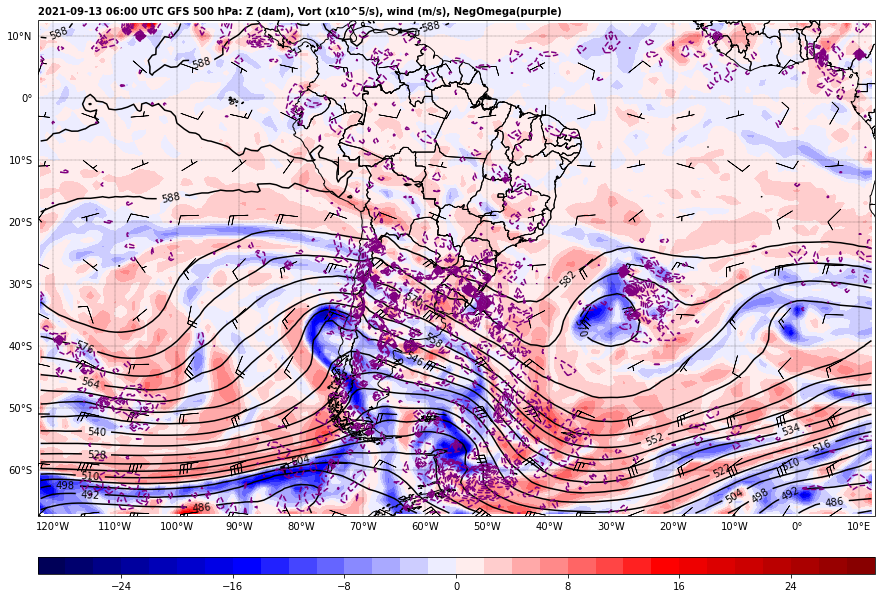

In [10]:
# Plotando 500: Z, vort

# Choose the plot size (width x height, in inches)
plt.figure(figsize=(15,15))

# Use the Geostationary projection in cartopy
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([extent[0], extent[2], extent[1], extent[3]], ccrs.PlateCarree())

# 500-hPa vort
clevzeta = np.arange(-30, 31, 2)
zeta = ax.contourf(lons, lats, zeta_500*10**5, clevzeta, cmap='seismic', transform=ccrs.PlateCarree())
plt.colorbar(zeta, orientation='horizontal', pad=0.05, aspect=50, extendrect=True)

# Plot Geopotential Heights
clevs_hght_500 = np.arange(0, 800, 6)
cs = ax.contour(lons, lats, hght_500/10, clevs_hght_500, colors='black', transform=ccrs.PlateCarree())
plt.clabel(cs, fmt='%d')

# Plot Omega
clevs_w_500 = np.arange(-50,0,0.3)
csw = ax.contour(lons, lats, w_500, clevs_w_500, colors='purple',linewidth=0.25, transform=ccrs.PlateCarree())
#plt.clabel(cs, fmt='%d')

# Create a flag to determine which barbs are flipped
flip_flag = np.zeros((u_500.shape[0],u_500.shape[1]))

# All flags below the equator will be flipped
flip_flag[lats < 0] = 1

# Plot the barbs
skip=8
bcolor='black'
img4 = ax.barbs(lons[::skip,::skip], lats[::skip,::skip], u_500[::skip,::skip], v_500[::skip,::skip], length = 6.0, sizes = dict(emptybarb=0.0, spacing=0.2, height=0.5), linewidth=0.7, pivot='middle', barbcolor=bcolor, flip_barb = flip_flag[::skip,::skip])


states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)
# Add country borders to plot
country_borders = cfeature.NaturalEarthFeature(category='cultural',
                                               name='admin_0_countries',
                                               scale='50m', facecolor='none')
ax.add_feature(country_borders, edgecolor='black', linewidth=1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='black', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 10), ylocs=np.arange(-90, 90, 10), draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Extract date
date = (datetime.strptime(dtime, '%Y-%m-%dT%H:%M:%S.%fZ'))

# Add a title
plt.title(date.strftime('%Y-%m-%d %H:%M') + ' UTC' + ' GFS 500 hPa: Z (dam), Vort (x10^5/s), wind (m/s), NegOmega(purple)', fontweight='bold', fontsize=10, loc='left')
#plt.title('Reg.: ' + str(extent) , fontsize=10, loc='right')
#-----------------------------------------------------------------------------------------------------------
# Save the image
plt.savefig(f'{output}/500_Vort.png', bbox_inches='tight', pad_inches=0, dpi=300)

# Show the image
plt.show()


C:\Users\ritay\anaconda3\envs\satelite\lib\site-packages\cartopy\mpl\geoaxes.py:1548: UserWarning: The following kwargs were not used by contour: 'linestyle'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


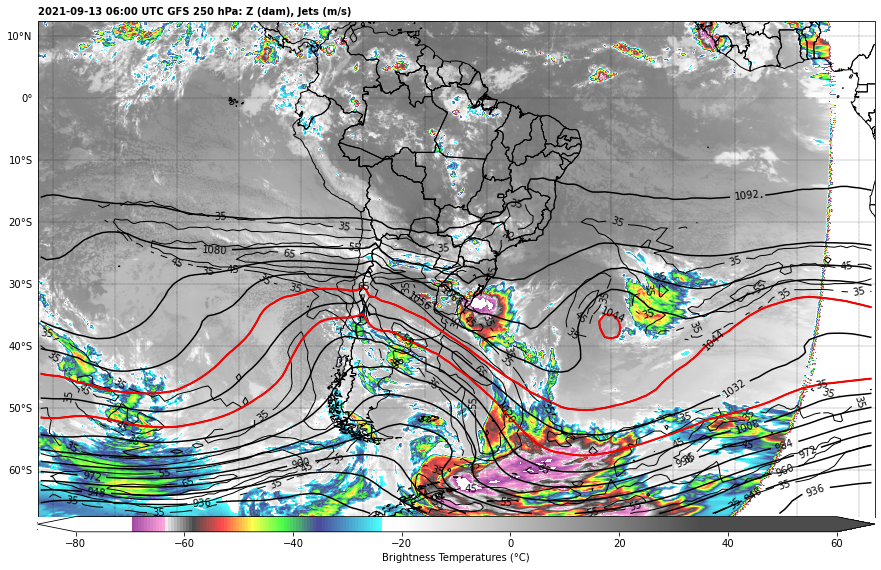

In [14]:
# Plotando 250: Z e jatos

# Choose the plot size (width x height, in inches)
plt.figure(figsize=(15,15))

# Use the Geostationary projection in cartopy
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([extent[0], extent[2], extent[1], extent[3]], ccrs.PlateCarree())

# Define the image extent
img_extent = [extent[0], extent[2], extent[1], extent[3]]

# Define the color scale based on the channel
# Converts a CPT file to be used in Python
cpt = loadCPT('IR4AVHRR6.cpt')
colormap = cm.colors.LinearSegmentedColormap('cpt', cpt) 
    
# Plot the image
img1 = ax.imshow(data, origin='upper', vmin=-80, vmax=60, extent=img_extent, cmap=colormap, alpha=0.7)
# Add a colorbar
plt.colorbar(img1, label='Brightness Temperatures (°C)', extend='both', orientation='horizontal', pad=0, aspect = 50)

# Plot jets
clevs_jet = np.arange(35,86,10)
cjet = ax.contour(lons, lats, speed_jet, clevs_jet, colors='black',linestyle='dotted',linewidths=1, transform=ccrs.PlateCarree())
plt.clabel(cjet, fmt='%d')

# Plot Geopotential Heights
clevs_hght_250 = np.arange(0, 2000, 12)
cs = ax.contour(lons, lats, hght_250/10, clevs_hght_250, colors='black', transform=ccrs.PlateCarree())
plt.clabel(cs, fmt='%d')

# Plot Z
clevzjet = np.arange(10200., 10500., 240)
cs = ax.contour(lons, lats, hght_250, clevzjet, colors='red', linewidths=2.0,linestyles='solid',transform=ccrs.PlateCarree())


states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)
# Add country borders to plot
country_borders = cfeature.NaturalEarthFeature(category='cultural',
                                               name='admin_0_countries',
                                               scale='50m', facecolor='none')
ax.add_feature(country_borders, edgecolor='black', linewidth=1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='black', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 10), ylocs=np.arange(-90, 90, 10), draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Extract date
date = (datetime.strptime(dtime, '%Y-%m-%dT%H:%M:%S.%fZ'))

# Add a title
plt.title(date.strftime('%Y-%m-%d %H:%M') + ' UTC' + ' GFS 250 hPa: Z (dam), Jets (m/s)', fontweight='bold', fontsize=10, loc='left')
#plt.title('Reg.: ' + str(extent) , fontsize=10, loc='right')
#-----------------------------------------------------------------------------------------------------------
# Save the image
plt.savefig(f'{output}/250_Sat_Jatos.png', bbox_inches='tight', pad_inches=0, dpi=300)

# Show the image
plt.show()


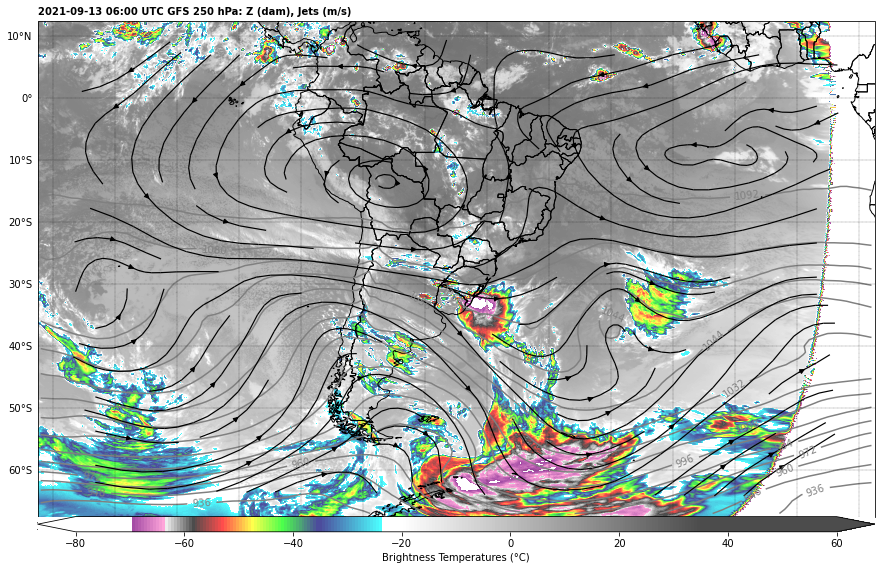

In [11]:
# Plotando 250: Z e jatos

# Choose the plot size (width x height, in inches)
plt.figure(figsize=(15,15))

# Use the Geostationary projection in cartopy
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([extent[0], extent[2], extent[1], extent[3]], ccrs.PlateCarree())

# Define the image extent
img_extent = [extent[0], extent[2], extent[1], extent[3]]

# Define the color scale based on the channel
# Converts a CPT file to be used in Python
cpt = loadCPT('IR4AVHRR6.cpt')
colormap = cm.colors.LinearSegmentedColormap('cpt', cpt) 
    
# Plot the image
img1 = ax.imshow(data, origin='upper', vmin=-80, vmax=60, extent=img_extent, cmap=colormap, alpha=0.7)
# Add a colorbar
plt.colorbar(img1, label='Brightness Temperatures (°C)', extend='both', orientation='horizontal', pad=0, aspect = 50)

# Plot jets
#clevs_jet = np.arange(35,86,10)
#cjet = ax.contour(lons, lats, speed_jet, clevs_jet, colors='black',linestyle='dotted',linewidths=1, transform=ccrs.PlateCarree())
#plt.clabel(cjet, fmt='%d')

# Plot Geopotential Heights
clevs_hght_250 = np.arange(0, 2000, 12)
cs = ax.contour(lons, lats, hght_250/10, clevs_hght_250, colors='gray', transform=ccrs.PlateCarree())
plt.clabel(cs, fmt='%d')

# Plot Z
#clevzjet = np.arange(10200., 10500., 240)
#cs = ax.contour(lons, lats, hght_250, clevzjet, colors='red', linewidths=2.0,linestyles='solid',transform=ccrs.PlateCarree())

ax.streamplot(lons, lats, u_250, v_250, density=[1, 1], linewidth=1.2, color='black')

states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)
# Add country borders to plot
country_borders = cfeature.NaturalEarthFeature(category='cultural',
                                               name='admin_0_countries',
                                               scale='50m', facecolor='none')
ax.add_feature(country_borders, edgecolor='black', linewidth=1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='black', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 10), ylocs=np.arange(-90, 90, 10), draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Extract date
date = (datetime.strptime(dtime, '%Y-%m-%dT%H:%M:%S.%fZ'))

# Add a title
plt.title(date.strftime('%Y-%m-%d %H:%M') + ' UTC' + ' GFS 250 hPa: Z (dam), Jets (m/s)', fontweight='bold', fontsize=10, loc='left')
#plt.title('Reg.: ' + str(extent) , fontsize=10, loc='right')
#-----------------------------------------------------------------------------------------------------------
# Save the image
plt.savefig(f'{output}/250_Sat_LC.png', bbox_inches='tight', pad_inches=0, dpi=300)

# Show the image
plt.show()


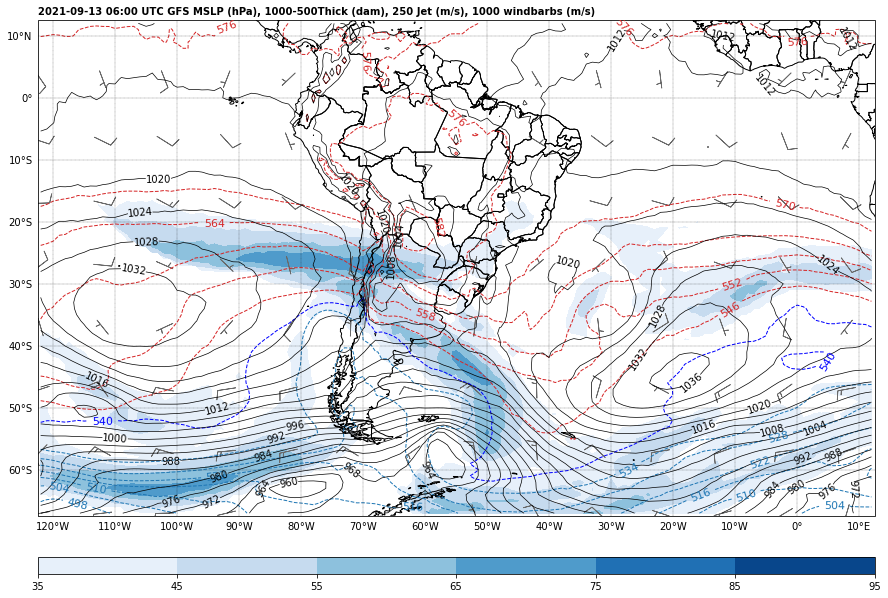

In [15]:
# Plotando 250: Z e jatos

# Choose the plot size (width x height, in inches)
plt.figure(figsize=(15,15))

# Use the Geostationary projection in cartopy
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([extent[0], extent[2], extent[1], extent[3]], ccrs.PlateCarree())

# 250-hPa jet
clevjet = np.arange(35,96,10)
jet250 = ax.contourf(lons, lats, speed_jet, clevjet, cmap='Blues', transform=ccrs.PlateCarree())
plt.colorbar(jet250, orientation='horizontal', pad=0.05, aspect=50, extendrect=True)

# Plot thickness with multiple colors
clevs = (np.arange(0, 540, 6),
         np.array([540]),
         np.arange(546, 700, 6))
colors = ('tab:blue', 'b', 'tab:red')
kw_clabels = {'fontsize': 11, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}
for clevthick, color in zip(clevs, colors):
    img2 = ax.contour(lons, lats, thickness_1000_500/10, levels=clevthick, colors=color,
                    linewidths=1.0, linestyles='dashed', transform=ccrs.PlateCarree())
    plt.clabel(img2, **kw_clabels)

# Define de contour interval
data_min = 900
data_max = 1050
interval = 4
levels = np.arange(data_min,data_max,interval)

# Plot the contours
img3 = ax.contour(lons, lats, mslp, colors='black', linewidths=0.7, levels=levels)
ax.clabel(img3, inline=1, inline_spacing=0, fontsize='10',fmt = '%1.0f', colors= 'black')


# Create a flag to determine which barbs are flipped
flip_flag = np.zeros((u_1000.shape[0],u_1000.shape[1]))

# All flags below the equator will be flipped
flip_flag[lats < 0] = 1

# Plot the barbs
skip=10
bcolor='dimgrey'
img4 = ax.barbs(lons[::skip,::skip], lats[::skip,::skip], u_1000[::skip,::skip], v_1000[::skip,::skip], length = 6.0, sizes = dict(emptybarb=0.0, spacing=0.2, height=0.5), linewidth=0.8, pivot='middle', barbcolor=bcolor, flip_barb = flip_flag[::skip,::skip])

states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)
# Add country borders to plot
country_borders = cfeature.NaturalEarthFeature(category='cultural',
                                               name='admin_0_countries',
                                               scale='50m', facecolor='none')
ax.add_feature(country_borders, edgecolor='black', linewidth=1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='black', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 10), ylocs=np.arange(-90, 90, 10), draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Extract date
date = (datetime.strptime(dtime, '%Y-%m-%dT%H:%M:%S.%fZ'))

# Add a title
plt.title(date.strftime('%Y-%m-%d %H:%M') + ' UTC' + ' GFS MSLP (hPa), 1000-500Thick (dam), 250 Jet (m/s), 1000 windbarbs (m/s)', fontweight='bold', fontsize=10, loc='left')
#plt.title('Reg.: ' + str(extent) , fontsize=10, loc='right')
#-----------------------------------------------------------------------------------------------------------
# Save the image
plt.savefig(f'{output}/MSLP_Thick_Jatos.png', bbox_inches='tight', pad_inches=0, dpi=300)

# Show the image
plt.show()
